In [2]:
import warnings

import firedrake as fd
import movement as mv
import torch
import warpmesh as wm
from torch_geometric.data import DataLoader

warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available()
else 'cpu')

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [20]:
x = torch.tensor([
    [1, 2, 3],
    [2, 3, 4],
    [3, 4, 5],
    [4, 5, 6],
], dtype=torch.float,requires_grad=True)

print(x.shape)

def my_func(in_data):
    x = in_data[:, 0]
    y = in_data[:, 1]
    z = in_data[:, 2]
    x_out = y + x*y*z + 3*y**2
    y_out = x + 2*x*y*z + x**2
    return torch.stack((x_out, y_out), dim=1)

def ten2tup(in_data):
    data = my_func(in_data)
    x = data[:, 0]
    y = data[:, 1]
    return (x, y)

y = my_func(x)

y

torch.Size([4, 3])


tensor([[ 20.,  14.],
        [ 54.,  54.],
        [112., 132.],
        [200., 260.]], grad_fn=<StackBackward0>)

In [31]:
dXdx = torch.autograd.grad(
    outputs=y[:, 0],
    inputs=x,
    create_graph=True,
    grad_outputs=torch.ones_like(y[:, 0]),
)[0][:, :2]

dXdy = torch.autograd.grad(
    outputs=y[:, 1],
    inputs=x,
    create_graph=True,
    grad_outputs=torch.ones_like(y[:, 1]),
)[0][:, :2]

jacobian = torch.stack([dXdx, dXdy], dim=1)

determinants = (
    jacobian[:, 0, 0] * jacobian[:, 1, 1] -
    jacobian[:, 0, 1] * jacobian[:, 1, 0]
)


print(dXdx)
print()
print(dXdy)
print()
print(jacobian)
print()
print(determinants)

tensor([[ 6., 16.],
        [12., 27.],
        [20., 40.],
        [30., 55.]], grad_fn=<SliceBackward0>)

tensor([[15.,  6.],
        [29., 16.],
        [47., 30.],
        [69., 48.]], grad_fn=<SliceBackward0>)

tensor([[[ 6., 16.],
         [15.,  6.]],

        [[12., 27.],
         [29., 16.]],

        [[20., 40.],
         [47., 30.]],

        [[30., 55.],
         [69., 48.]]], grad_fn=<StackBackward0>)

tensor([ -204.,  -591., -1280., -2355.], grad_fn=<SubBackward0>)


In [5]:
n_elem_x = n_elem_y = 30

loss_func = torch.nn.L1Loss()

normalise = True

data_dir = f'/Users/cw1722/Documents/irp/irp-cw1722/data/dataset/helmholtz/z=<0,1>_ndist=None_max_dist=6_<{n_elem_x}x{n_elem_y}>_n=400_smpl/val'

weight_path = "/Users/cw1722/Downloads/model_1499 (7).pth"


prediction_dir = "/Users/cw1722/Documents/irp/irp-cw1722/data/temp"

model = wm.MRN(
    deform_in_c=7,
    gfe_in_c=2,
    lfe_in_c=4,
    num_loop=3
).to(device)


model = wm.load_model(model, weight_path)


normalise = True

x_feat = [
    "coord",
    "bd_mask",
    "bd_left_mask",
    "bd_right_mask",
    "bd_down_mask",
    "bd_up_mask",
]
mesh_feat = [
    "coord",
    "u",
    "hessian_norm",
    # "grad_u",
    # "hessian",
]
conv_feat = [
    "conv_uh",
    "conv_hessian_norm",
]


In [6]:
idx = 6

data_set = wm.MeshDataset(
    data_dir,
    transform=wm.normalise if normalise else None,
    x_feature=x_feat,
    mesh_feature=mesh_feat,
    conv_feature=conv_feat,
)

loader = DataLoader(data_set, batch_size=10)

in_data = data_set[idx]
in_data.x.requires_grad_(True)

mesh = fd.UnitSquareMesh(n_elem_x, n_elem_y)
checker = mv.MeshTanglingChecker(mesh, mode='warn')

out = model(in_data)

mesh.coordinates.dat.data[:] = out.detach().numpy()[:]

dXdx = torch.autograd.grad(
    outputs=out[:, 0],
    inputs=in_data.x,
    create_graph=True,
    grad_outputs=torch.ones_like(out[:, 0]),
)[0][:, :2]

dXdy = torch.autograd.grad(
    outputs=out[:, 1],
    inputs=in_data.x,
    create_graph=True,
    grad_outputs=torch.ones_like(out[:, 1]),
)[0][:, :2]


det = dXdx[:, 0] * dXdy[:, 1] - dXdx[:, 1] * dXdy[:, 0]

print(det[det < 0])

model_tangle = torch.sum(det < 0).item()
analytic_tangle = checker.check()

print(model_tangle)
print(analytic_tangle)

tensor([-0.0038, -0.0031, -0.0011, -0.0004, -0.0004], grad_fn=<IndexBackward0>)
5
0


In [8]:
in_data.x.shape

torch.Size([961, 7])

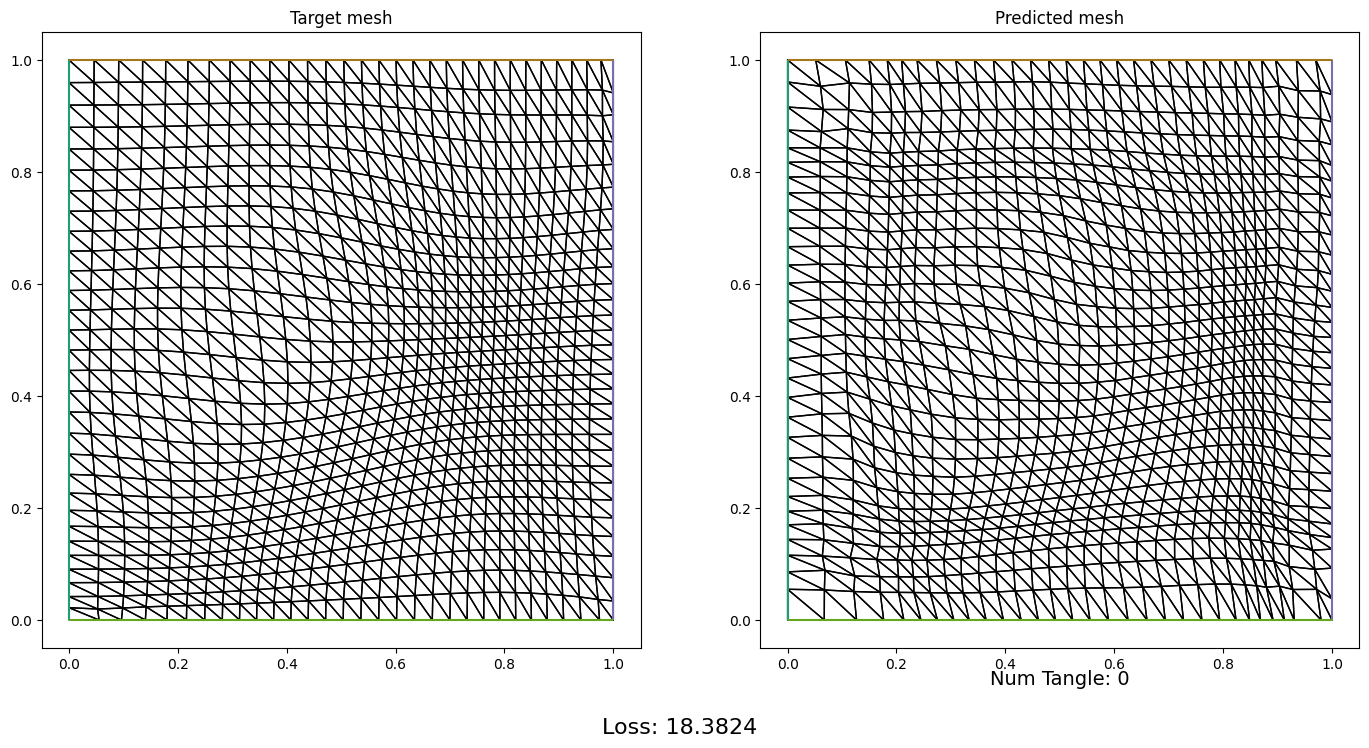

In [40]:
wm.plot_sample(model, in_data, prediction_dir,
                loss_func, n_elem_x, n_elem_y, 0, "test", savefig=False)
